# **DRUG SPENDING ANALYSIS AND PREDICTIVE DECISION SUPPORT USING MEDICAID UTILIZATION DATA**

## **1. Business Understanding**

### **1.1 Business Overview**

Medicaid spends millions of dollars each year on prescription drugs for patients across the United States, and this expenditure has been steadily increasing, making it challenging for administrators and policymakers to monitor and control costs effectively. Current reporting systems mainly focus on past spending and fail to provide accurate forecasts or actionable insights for future decision-making. This project aims to address these challenges by combining data analytics and predictive modeling to both analyze historical Medicaid drug utilization patterns and forecast future expenditures. By identifying high-cost drugs, overutilized prescriptions, and spending variations across states and drug categories, the project seeks to provide a comprehensive understanding of where resources are being used and how they can be optimized.

Furthermore, predictive insights will allow stakeholders to anticipate spending trends, plan budgets proactively, and implement cost-saving strategies such as promoting generic alternatives or managing overprescription. Ultimately, the project intends to transform large volumes of Medicaid drug data into a decision-support tool that empowers administrators, policymakers, and healthcare stakeholders to make informed, data-driven decisions that improve efficiency, reduce unnecessary costs, and ensure sustainable management of Medicaid drug spending.

## **1.2 Problem Statement**

Healthcare programs such as Medicaid spend large amounts of money on prescription drugs each year. Monitoring and controlling this spending is important for budgeting, policy planning, and ensuring efficient allocation of resources. However, the large volume of drug utilization data makes it difficult to quickly identify spending patterns, high-cost drugs, and trends in reimbursement.

Existing reporting systems mainly focus on describing past expenditures but do not effectively support prediction of future spending or early identification of cost drivers. This limits the ability of decision makers to plan budgets and implement cost-control measures proactively.

This project aims to analyze Medicaid drug utilization data to identify key spending patterns and build a machine learning model capable of predicting drug reimbursement spending based on utilization metrics. In addition, a simple web-based tool will be developed to demonstrate how such predictions could support planning and decision making.


## **1.3 Business Objectives**
### **1.3.1 Main Objective**
To analyze drug utilization patterns and develop a predictive model for estimating reimbursement spending using Medicaid drug utilization data.

### **1.3.2 Specific Objectives**
1. Which drugs account for the highest total Medicaid reimbursement spending?
2. Which drugs are most frequently prescribed?
3. How does drug utilization and reimbursement spending vary across states?
4. How accurately can Medicaid drug spending be predicted using drug identity and utilization characteristics?
5. What actionable insights can be derived from these findings to support better Medicaid spending decisions?

## **1.4 Success Criteria**

- **Predictive Performance:**  
  Achieve an R² greater than **80% (≥ 0.80)** on cross-validation and hold-out test data, demonstrating strong explanatory power and reliable generalization.

- **Model Stability:**  
  Maintain low variance between cross-validation and test performance (minimal performance gap), indicating robustness and resistance to overfitting.

- **Interpretability & Transparency:**  
  Clearly identify and interpret key spending drivers using SHAP analysis, ensuring insights are actionable for policymakers.

- **Business Relevance:**  
  Generate findings that directly inform Medicaid budget planning, utilization management strategies, and state-level benchmarking efforts.

- **Scalability & Deployment Readiness:**  
  Develop a modeling framework that can be extended to future datasets, integrated into dashboards, or adapted for ongoing monitoring and forecasting.

- **Policy Impact Potential:**  
  Provide actionable recommendations that support proactive cost-containment strategies while maintaining equitable access to essential medications.

## **2. Data Understanding and Key Stakeholders**

## **2.1 Data Understanding**

The dataset used in this project is the **State Drug Utilization Data (SDUD)** provided by the Centers for Medicare & Medicaid Services (CMS), sourced from Data.gov:
[https://catalog.data.gov/dataset/state-drug-utilization-data-2025](https://catalog.data.gov/dataset/state-drug-utilization-data-2025)

The raw dataset contains Medicaid drug utilization records reported at the National Drug Code (NDC) level. After data cleaning and aggregation, the analytical dataset consists of **603,682 observations**, structured at the **drug–state–quarter level**, where each observation represents the total utilization and reimbursement spending for a specific drug within a given state and quarter.

Aggregation was performed to consolidate fragmented NDC-level entries and ensure consistent measurement of drug-level spending patterns.

### **Target Variable**

* **`log_spending`**: Natural logarithm of total Medicaid reimbursement per drug–state–quarter.
  This transformation reduces skewness associated with extreme high-cost drugs and improves model stability and predictive performance.

### **Feature Variables**

* **`Units Reimbursed`**: Total quantity of drug units dispensed.
* **`Number of Prescriptions`**: Total prescriptions filled.
* **`utilization_intensity`**: Engineered feature capturing the interaction between prescription frequency and drug volume.
* **`Product Name`**: Drug identifier (target-encoded in predictive modeling).
* **`State`**: U.S. state where the drug was reimbursed.
* **`Quarter`**: Reporting period of observation.

These variables support both descriptive analysis (identifying high-cost and high-utilization drugs) and predictive modeling of Medicaid reimbursement spending patterns.

## **2.2 Key Stakeholders**

**1. Medicaid Administrators and Program Managers**
Use spending analysis and forecasts to plan budgets and monitor high-cost drugs.

**2. State and Federal Policymakers**
Design funding policies and cost-containment strategies based on evidence of spending concentration and state-level variation.

**3. Taxpayers and the General Public**
Fund Medicaid programs and benefit from efficient, transparent allocation of public resources.


## **3. Data Preparation and EDA**
### **3.1 Importing libraries**
The necessary python libraries for data cleaning, visualizations and modeling are imported. These include pandas, Numpy, Scikit-learn and many others.

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### **3.2 Data loading and Inspection**
In this section the State Drug Utilization Data 2025 is loaded from a CSV file ito a pandas DataFrame. Basic inspection functions are applied to confirm successful loading and preview the structure of the dataset before further analysis.

In [2]:
df = pd.read_csv("./data/Medicaid_data.csv")
df.head()

,Utilization Type,State,NDC,Labeler Code,Product Code,Package Size,Year,Quarter,Suppression Used,Product Name,Units Reimbursed,Number of Prescriptions,Total Amount Reimbursed,Medicaid Amount Reimbursed,Non Medicaid Amount Reimbursed
0,FFSU,AK,2143380,2,1433,80,2025,2,False,TRULICITY,216.0,107.0,102976.40,98630.87,4345.53
1,FFSU,AK,2143480,2,1434,80,2025,2,False,TRULICITY,218.0,109.0,104481.92,101806.64,2675.28
2,FFSU,AK,2143611,2,1436,11,2025,2,False,EMGALITY P,21.0,20.0,15227.25,15227.25,0.00
3,FFSU,AK,2144511,2,1445,11,2025,2,False,TALTZ AUTO,33.0,30.0,231532.28,231532.28,0.00
4,FFSU,AK,2145780,2,1457,80,2025,2,False,MOUNJARO,208.0,104.0,108908.80,105953.32,2955.48


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1313397 entries, 0 to 1313396
Data columns (total 15 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   Utilization Type                1313397 non-null  object 
 1   State                           1313397 non-null  object 
 2   NDC                             1313397 non-null  int64  
 3   Labeler Code                    1313397 non-null  int64  
 4   Product Code                    1313397 non-null  int64  
 5   Package Size                    1313397 non-null  int64  
 6   Year                            1313397 non-null  int64  
 7   Quarter                         1313397 non-null  int64  
 8   Suppression Used                1313397 non-null  bool   
 9   Product Name                    1313397 non-null  object 
 10  Units Reimbursed                1313397 non-null  float64
 11  Number of Prescriptions         1313397 non-null  float64
 12  

In [4]:
df.isna().sum()

Utilization Type                  0
State                             0
NDC                               0
Labeler Code                      0
Product Code                      0
Package Size                      0
Year                              0
Quarter                           0
Suppression Used                  0
Product Name                      0
Units Reimbursed                  0
Number of Prescriptions           0
Total Amount Reimbursed           0
Medicaid Amount Reimbursed        0
Non Medicaid Amount Reimbursed    0
dtype: int64

In [5]:
df.duplicated().value_counts()

False    1313397
Name: count, dtype: int64

### **3.3 Outlier Analysis using IQR**

In [6]:
# Target column selection
column = "Total Amount Reimbursed"

Q1 = df[column].quantile(0.25)
Q3 = df[column].quantile(0.75)

IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]

print("Lower Bound:", lower_bound)
print("Upper Bound:", upper_bound)
print("Number of Outliers:", outliers.shape[0])
print("Percentage of Outliers:", (outliers.shape[0] / df.shape[0]) * 100)

Lower Bound: -9221.155
Upper Bound: 16410.325
Number of Outliers: 210679
Percentage of Outliers: 16.040770612389093


The distribution of **Total Amount Reimbursed** exhibited significant right skewness, with approximately **16.04% of observations falling outside the IQR upper bound**.
The outliers will be handled through log trasformation at a later stage.

### **3.4 Exploratory Data Analysis (EDA)**

In [7]:
# Standardizing Product Names
import re
def clean_product_name(x):
    if pd.isna(x): return np.nan
    x = str(x).strip()
    x = re.sub(r"\s+", " ", x)
    return x.casefold()

df["Product Name"] = df["Product Name"].apply(clean_product_name)

# Drop national aggregate row
df = df[df['State'] != 'XX'].copy()
print("Shape after cleaning:", df.shape)

Shape after cleaning: (1194315, 15)


In [8]:
# Drop the national "XX" row
df = df[df['State'] != 'XX'].copy()
print("Dataset shape after removing XX:", df.shape)
print("Remaining states:", sorted(df['State'].unique()))

Dataset shape after removing XX: (1194315, 15)
Remaining states: ['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']


In [9]:
df.drop(columns=["Product Name_raw"], inplace=True, errors="ignore")

#### **3.4.1 Cumulative Spending Threshold**

Medicaid drug spending is highly concentrated, with a small subset of drugs accounting for most total reimbursement. A cumulative spending threshold (80–90%) was applied to retain the most financially significant drugs.

This approach focuses the analysis on material cost drivers while reducing noise from low-impact drugs, improving interpretability and model stability.

In [10]:
drug_spending = (
    df.groupby("Product Name")["Total Amount Reimbursed"]
      .sum()
      .sort_values(ascending=False)
)

cumulative_spending = drug_spending.cumsum() / drug_spending.sum()

top_drugs = cumulative_spending[cumulative_spending <= 0.85].index  # 85% threshold

df_filtered = df[df["Product Name"].isin(top_drugs)].copy()

print("Unique drugs kept:", len(top_drugs))


Unique drugs kept: 683



#### **3.4.2 Feature Engineering**

Two feature enhancements were applied to improve clarity and predictive performance. First, state abbreviations were mapped to their full names to enhance interpretability in visualizations and comparative analysis. Second, a new feature, **`utilization_intensity`**, was created to capture the interaction between prescription volume and units reimbursed, allowing the model to better reflect the combined effect of drug demand and dispensing volume on total spending.

In [11]:
# Adding  State Full Name for interpretability
state_names = {
    "AL": "Alabama", "AK": "Alaska", "AZ": "Arizona", "AR": "Arkansas",
    "CA": "California", "CO": "Colorado", "CT": "Connecticut", "DE": "Delaware",
    "FL": "Florida", "GA": "Georgia", "HI": "Hawaii", "ID": "Idaho",
    "IL": "Illinois", "IN": "Indiana", "IA": "Iowa", "KS": "Kansas",
    "KY": "Kentucky", "LA": "Louisiana", "ME": "Maine", "MD": "Maryland",
    "MA": "Massachusetts", "MI": "Michigan", "MN": "Minnesota", "MS": "Mississippi",
    "MO": "Missouri", "MT": "Montana", "NE": "Nebraska", "NV": "Nevada",
    "NH": "New Hampshire", "NJ": "New Jersey", "NM": "New Mexico", "NY": "New York",
    "NC": "North Carolina", "ND": "North Dakota", "OH": "Ohio", "OK": "Oklahoma",
    "OR": "Oregon", "PA": "Pennsylvania", "RI": "Rhode Island",
    "SC": "South Carolina", "SD": "South Dakota", "TN": "Tennessee",
    "TX": "Texas", "UT": "Utah", "VT": "Vermont", "VA": "Virginia",
    "WA": "Washington", "WV": "West Virginia", "WI": "Wisconsin", "WY": "Wyoming",
    "DC": "District of Columbia", "PR": "Puerto Rico"
}
df_filtered["State Full Name"] = df_filtered["State"].map(state_names)


In [12]:
# Utilization Intensity Feature
df_filtered["utilization_intensity"] = (df_filtered["Units Reimbursed"] * 
                                        df_filtered["Number of Prescriptions"])


#### **3.4.3 Most expensive drugs in the market (Objective 1)** 


In [13]:
top_15_drugs = (
    df_filtered.groupby("Product Name")["Total Amount Reimbursed"]
      .sum()
      .sort_values(ascending=False)
      .head(15)
)
top_15_drugs.head(15)


Product Name
biktarvy      1.487752e+09
jardiance     1.224935e+09
trulicity     9.942157e+08
invega sus    8.841717e+08
humira(cf)    8.621136e+08
humira pen    7.755576e+08
ozempic       6.612600e+08
dupixent s    6.432030e+08
eliquis       6.114578e+08
zepbound      5.080595e+08
dupixent p    4.911089e+08
ozempic 0.    4.176484e+08
abilify ma    4.130071e+08
stelara 90    3.995239e+08
vraylar (c    3.830521e+08
Name: Total Amount Reimbursed, dtype: float64

In [14]:
# Changing the series to a dataframe
most_exp_drugs = top_15_drugs.reset_index()

# Naming columns for the new Dataframe
most_exp_drugs.columns = ["Product Name", "Total Amount Reimbursed"]
most_exp_drugs

,Product Name,Total Amount Reimbursed
0,biktarvy,1.487752e+09
1,jardiance,1.224935e+09
2,trulicity,9.942157e+08
3,invega sus,8.841717e+08
4,humira(cf),8.621136e+08
5,humira pen,7.755576e+08
6,ozempic,6.612600e+08
7,dupixent s,6.432030e+08
8,eliquis,6.114578e+08
9,zepbound,5.080595e+08


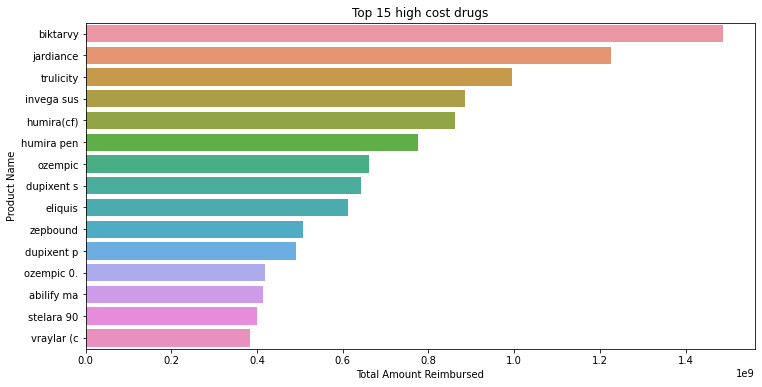

In [15]:
import seaborn as sns
# ploting top 15 high cost drugs
plt.figure(figsize=(12,6))
sns.barplot(data=most_exp_drugs, x="Total Amount Reimbursed", y="Product Name")
plt.title('Top 15 high cost drugs')
plt.xlabel("Total Amount Reimbursed")
plt.ylabel('Product Name')
plt.show()

As part of the objective to identify key cost drivers, the analysis shows that pharmaceutical spending is heavily concentrated among a small group of medications, with **Biktarvy**, **Jardiance**, and **Trulicity** leading total expenditures. The presence of multiple formulations of drugs such as **Humira** and **Ozempic** further amplifies their financial impact. Overall, diabetes, autoimmune, and psychiatric treatments dominate the top spending category, indicating that chronic disease management is a major driver of total healthcare costs and a critical area for targeted cost-control strategies.

#### **3.4.4 Most popular drugs as per presciptions (Objective 2)**

In [16]:
# Filtering the most popular 
common_drugs = (
    df_filtered.groupby("Product Name")["Number of Prescriptions"]
      .sum()
      .sort_values(ascending=False)
      .head(15)
)
common_drugs.head(15)


Product Name
amoxicilli    8243538.0
albuterol     7264826.0
ibuprofen     6543001.0
fluticason    6042960.0
atorvastat    5987791.0
gabapentin    5969243.0
ondansetro    5741383.0
cetirizine    5275403.0
metformin     4655398.0
sertraline    4481159.0
hydroxyzin    4438048.0
omeprazole    4397245.0
amlodipine    4231409.0
lisinopril    4016472.0
trazodone     3957128.0
Name: Number of Prescriptions, dtype: float64

In [17]:
# Changing into a dataframe
popular_drugs = common_drugs.reset_index()
popular_drugs.columns = ["Product Name", "No of prescriptions"]
popular_drugs

,Product Name,No of prescriptions
0,amoxicilli,8243538.0
1,albuterol,7264826.0
2,ibuprofen,6543001.0
3,fluticason,6042960.0
4,atorvastat,5987791.0
5,gabapentin,5969243.0
6,ondansetro,5741383.0
7,cetirizine,5275403.0
8,metformin,4655398.0
9,sertraline,4481159.0


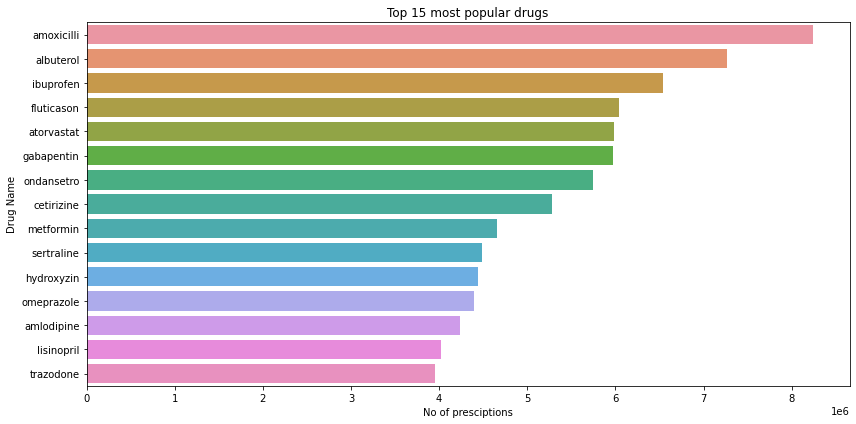

In [18]:
# Plotting the most popular drugs
plt.figure(figsize=(12,6))
sns.barplot(data=popular_drugs, x="No of prescriptions", y="Product Name")
plt.title("Top 15 most popular drugs")
plt.xlabel("No of presciptions")
plt.ylabel("Drug Name")
plt.tight_layout()
plt.show()

As part of the objective to understand utilization patterns, the analysis identifies a group of highly prescribed medications led by **Amoxicillin**, **Albuterol**, and **Ibuprofen**, each with over 6 million prescriptions. Unlike the highest-spending drugs, these medications are largely common generics used to treat routine conditions such as infections, asthma, pain, hypertension, diabetes, and mental health disorders. Their high prescription volume reflects widespread population health needs and primary care utilization, indicating that while these drugs may not individually drive the highest costs, they represent significant demand and ongoing chronic disease management within the healthcare system.

#### **3.4.5 Drug usage and spending by state (Objective 3)**

In [19]:
num_states = df_filtered["State"].nunique()
num_states

52

In [20]:
# Filtering by the total spending per state
state_spending = (
    df_filtered.groupby("State Full Name")["Total Amount Reimbursed"]
      .sum()
      .sort_values(ascending=False)
      .head(15)
)
state_spending.head(15)

State Full Name
California        6.730810e+09
New York          5.143920e+09
Pennsylvania      2.345845e+09
Ohio              2.009043e+09
North Carolina    2.001101e+09
Michigan          1.755784e+09
Illinois          1.442779e+09
Florida           1.387497e+09
Indiana           1.267096e+09
Virginia          1.240000e+09
Kentucky          1.181363e+09
Texas             1.163783e+09
Louisiana         1.108245e+09
Massachusetts     9.837195e+08
Wisconsin         9.464532e+08
Name: Total Amount Reimbursed, dtype: float64

In [21]:
# Changing into a dataframe
state_spending_df = state_spending.reset_index()
state_spending_df.columns = ["State Full Name", "Total Amount Reimbursed"]
state_spending_df

,State Full Name,Total Amount Reimbursed
0,California,6.730810e+09
1,New York,5.143920e+09
2,Pennsylvania,2.345845e+09
3,Ohio,2.009043e+09
4,North Carolina,2.001101e+09
5,Michigan,1.755784e+09
6,Illinois,1.442779e+09
7,Florida,1.387497e+09
8,Indiana,1.267096e+09
9,Virginia,1.240000e+09


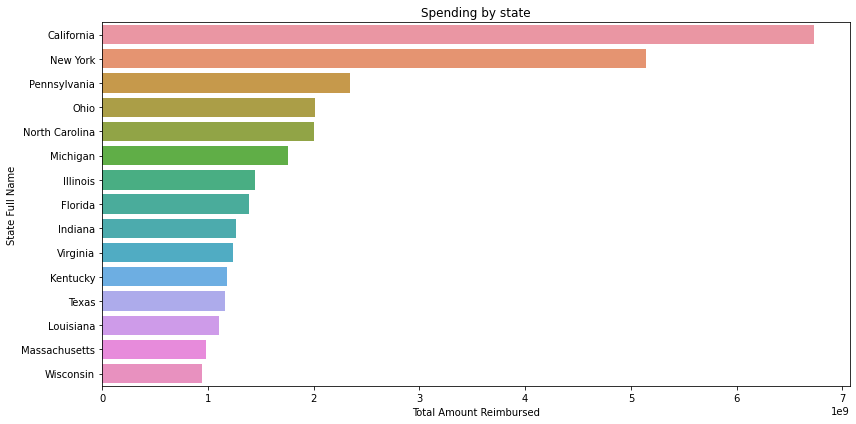

In [22]:
# Plotting spending by state
plt.figure(figsize=(12,6))
sns.barplot(data=state_spending_df, x="Total Amount Reimbursed", y="State Full Name")
plt.title("Spending by state")
plt.xlabel("Total Amount Reimbursed")
plt.ylabel("State Full Name")
plt.tight_layout()
plt.show()

In [23]:
# Filtering by units reimbursed
state_usage = (
    df_filtered.groupby("State Full Name")["Units Reimbursed"]
      .sum()
      .sort_values(ascending=False)
      .head(15)
)
state_usage.head(15)


State Full Name
California        2.037401e+09
New York          1.488311e+09
Ohio              7.663352e+08
Pennsylvania      7.039589e+08
Texas             6.490379e+08
North Carolina    5.959167e+08
Michigan          5.167147e+08
Florida           4.880454e+08
Kentucky          4.733878e+08
Illinois          4.474310e+08
Indiana           3.938806e+08
New Jersey        3.557094e+08
Virginia          3.473175e+08
Missouri          3.401117e+08
Massachusetts     3.317646e+08
Name: Units Reimbursed, dtype: float64

In [24]:
# Changing into a dataframe
state_usage_df = state_usage.reset_index()
state_usage_df.columns = ["State Full Name", "Units Reimbursed"]
state_usage_df

,State Full Name,Units Reimbursed
0,California,2.037401e+09
1,New York,1.488311e+09
2,Ohio,7.663352e+08
3,Pennsylvania,7.039589e+08
4,Texas,6.490379e+08
5,North Carolina,5.959167e+08
6,Michigan,5.167147e+08
7,Florida,4.880454e+08
8,Kentucky,4.733878e+08
9,Illinois,4.474310e+08


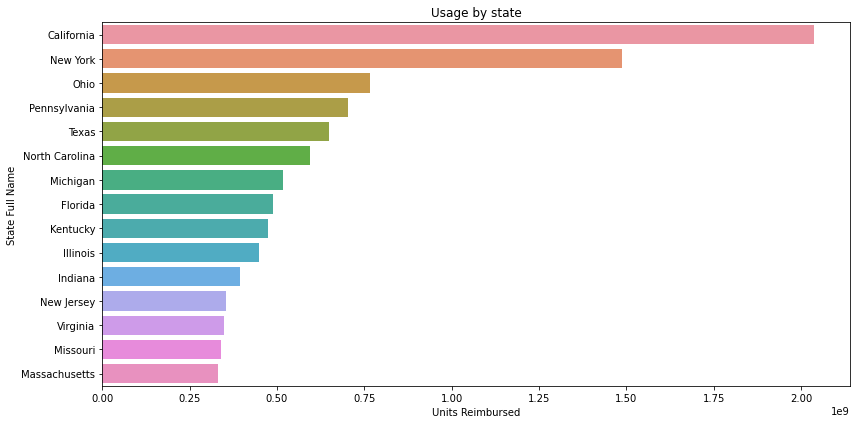

In [25]:
# Plotting usage by state
plt.figure(figsize=(12,6))
sns.barplot(data=state_usage_df, x="Units Reimbursed", y="State Full Name")
plt.title("Usage by state")
plt.xlabel("Units Reimbursed")
plt.ylabel("State Full Name")
plt.tight_layout()
plt.show()

As part of the third objective examining utilization by state and reimbursement differences, the analysis shows that pharmaceutical spending is heavily concentrated in larger states, with **California ($6.73B)** and **New York ($5.14B)** leading by a significant margin, followed by Pennsylvania, Ohio, and North Carolina. The total reimbursement figures mirror the overall spending distribution, suggesting a strong alignment between utilization volume and reimbursement amounts across states. These patterns likely reflect differences in population size, Medicaid enrollment levels, and disease burden rather than major reimbursement disparities, indicating that higher total spending is primarily driven by utilization scale rather than disproportionately higher per-unit reimbursement rates.

#### **3.4.6 Aggregating to State-Product-Quarter level** 
This aggregation step groups the filtered dataset by **State, Product Name, and Quarter** to create a summarized analytical dataset. Instead of analyzing individual transaction-level records, the data is consolidated by summing key metrics such as **Units Reimbursed, Number of Prescriptions, Total Amount Reimbursed, Medicaid Amount Reimbursed, and Non-Medicaid Amount Reimbursed** for each state–drug–quarter combination. This reduces the dataset’s dimensionality (as shown by the change in shape) while preserving total spending and utilization information, making it more suitable for state-level, product-level, and time-based trend analysis without losing aggregate financial accuracy.

In [26]:
df_model = (df_filtered
            .groupby(["State", "Product Name", "Quarter"], as_index=False)
            .agg({
                "Units Reimbursed": "sum",
                "Number of Prescriptions": "sum",
                "Total Amount Reimbursed": "sum",
                "utilization_intensity": "sum"
            }))

print("Final modelling dataset shape:", df_model.shape)

Final modelling dataset shape: (37542, 7)


In [27]:
df_model["utilization_intensity"] = (
    df_model["Units Reimbursed"] *
    df_model["Number of Prescriptions"]
)

#### **3.4.7 Log Transformation of Total Amount Reimbursed**

As mentioned before, the distribution of **Total Amount Reimbursed** exhibited significant right skewness, with approximately **16.04% of observations falling outside the IQR upper bound**. In this context, these “outliers” represent genuine high-cost drug reimbursements rather than data errors. Healthcare spending naturally follows a heavy-tailed distribution, where a small number of drugs account for disproportionately high costs. Therefore, removing these values would distort the true economic signal in the data.

Instead of eliminating observations, a **log(1 + x) transformation** was applied

In [28]:
df_model["log_spending"] = np.log1p(df_model["Total Amount Reimbursed"])

In [29]:
df_model.head()

,State,Product Name,Quarter,Units Reimbursed,Number of Prescriptions,Total Amount Reimbursed,utilization_intensity,log_spending
0,AK,abilify ma,1,82.000,82.0,222374.98,6724.000,12.312125
1,AK,abilify ma,2,88.000,88.0,229218.85,7744.000,12.342437
2,AK,acetaminop,1,15742.475,423.0,13084.82,6659066.925,9.479284
3,AK,acetaminop,2,13313.950,388.0,12600.74,5165812.600,9.441590
4,AK,adderall x,1,11497.000,384.0,51168.32,4414848.000,10.842895


In [30]:
df_model.columns

Index(['State', 'Product Name', 'Quarter', 'Units Reimbursed',
       'Number of Prescriptions', 'Total Amount Reimbursed',
       'utilization_intensity', 'log_spending'],
      dtype='object')

## **4. Data Pre-processing**

In [31]:
# Define features and target
X = df_model[["State", "Product Name", "Quarter", 
              "Units Reimbursed", "Number of Prescriptions", "utilization_intensity"]]
y = df_model["log_spending"]         

In [32]:
X.shape, y.shape

((37542, 6), (37542,))

### **Train Test Split**

In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

X_train.shape, X_test.shape


((28156, 6), (9386, 6))

### **Handling Categorical & Numerical Feature**

This section of the code defines feature categories for preprocessing and modeling purposes. **State** and **Quarter** are classified as *low-cardinality categorical variables*, meaning they contain a relatively limited number of unique values and can be efficiently One-Hot-encoded for analysis. **Product Name** is treated as a *high-cardinality categorical variable* due to the large number of unique drug names, which may require specialized encoding techniques (Target-Encoding) to avoid excessive dimensionality. The variables **Units Reimbursed**, **Number of Prescriptions**, and **utilization_intensity** are defined as *numeric features*, representing quantitative measures of drug usage and intensity that will be scaled or processed differently from categorical variables during model preparation.

In [34]:
categorical_low = ["State", "Quarter"]      
categorical_high = ["Product Name"]         
numeric_features = ["Units Reimbursed", "Number of Prescriptions", "utilization_intensity"]

### **Preprocessing Pipelines**

In [35]:
import category_encoders as ce
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat_low", OneHotEncoder(handle_unknown="ignore"), categorical_low),
        ("cat_high", ce.TargetEncoder(cols=categorical_high), categorical_high),
    ]
)

## **5. Modelling & Evaluation**

### **5.1 Linear Regression (Baseline)**

In [36]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

# Linear regression pipeline 
pipeline_lr = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("model", LinearRegression())
])

# Cross validation (CV) 
cv = KFold(n_splits=5, shuffle=True, random_state=42)

cv_r2 = cross_val_score(pipeline_lr, X, y, cv=cv, scoring="r2")
cv_mae = -cross_val_score(pipeline_lr, X, y, cv=cv, scoring="neg_mean_absolute_error")

print("Linear Regression CV R2 mean:", cv_r2.mean())
print("Linear Regression CV R2 std:", cv_r2.std())
print("Linear Regression CV MAE mean:", cv_mae.mean())
print("Linear Regression CV MAE std:", cv_mae.std())

# Fitting on Train and Evaluating on Test 
pipeline_lr.fit(X_train, y_train)
y_pred_lr = pipeline_lr.predict(X_test)

print("Linear Regression Test MAE:", mean_absolute_error(y_test, y_pred_lr))
print("Linear Regression Test R2:", r2_score(y_test, y_pred_lr))

Linear Regression CV R2 mean: 0.6512615457423354
Linear Regression CV R2 std: 0.01502237959706933
Linear Regression CV MAE mean: 0.7730845411235058
Linear Regression CV MAE std: 0.008725044528233463
Linear Regression Test MAE: 0.7797522879544173
Linear Regression Test R2: 0.6503699728819163


Linear Regression achieved a mean cross-validated performance of R² = 0.651 (SD = 0.015) and MAE = 0.773 (SD = 0.009), indicating stable generalization across folds. The single hold-out test results (R² = 0.650; MAE = 0.780) closely match the CV estimates, suggesting minimal sensitivity to the specific train/test split.

### **5.2 Random Forest**

In [37]:
from sklearn.ensemble import RandomForestRegressor

# Random Forest pipeline
pipeline_rf = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("model", RandomForestRegressor(
        n_estimators=50,
        max_depth=20,
        min_samples_split=2,
        min_samples_leaf=1,
        n_jobs=-1,
        random_state=42
    ))
])

# Cross validation
cv_r2_rf = cross_val_score(pipeline_rf, X, y, cv=cv, scoring="r2")
cv_mae_rf = -cross_val_score(pipeline_rf, X, y, cv=cv, scoring="neg_mean_absolute_error")

print("Random Forest CV R2 mean:", cv_r2_rf.mean())
print("Random Forest CV R2 std:", cv_r2_rf.std())
print("Random Forest CV MAE mean:", cv_mae_rf.mean())
print("Random Forest CV MAE std:", cv_mae_rf.std())

# Train/Test evaluation
pipeline_rf.fit(X_train, y_train)
y_pred_rf = pipeline_rf.predict(X_test)

print("Random Forest Test MAE:", mean_absolute_error(y_test, y_pred_rf))
print("Random Forest Test R2:", r2_score(y_test, y_pred_rf))

Random Forest CV R2 mean: 0.824354942195276
Random Forest CV R2 std: 0.008533236051228969
Random Forest CV MAE mean: 0.5035228144930242
Random Forest CV MAE std: 0.007309437610419349
Random Forest Test MAE: 0.5051443984429664
Random Forest Test R2: 0.8305291608587966


Random Forest substantially outperformed Linear Regression, achieving a mean cross-validated R² of 0.824 (SD = 0.009), compared to 0.651 for the linear baseline. The small standard deviation and close alignment between CV and test performance (Test R² = 0.831) indicate strong generalization and model stability across folds.

### **5.3 XGBoost Model**

In [38]:
from xgboost import XGBRegressor

# XGBoost Pipeline
pipeline_xgb = Pipeline([
    ("preprocessing", preprocessor),
    ("model", XGBRegressor(
        n_estimators=5000,          
        learning_rate=0.02,         
        max_depth=7,                
        min_child_weight=3,         
        subsample=0.9,
        colsample_bytree=0.9,
        reg_alpha=0.05,             
        reg_lambda=5.0,             
        gamma=0.0,
        objective="reg:squarederror",
        tree_method="hist",
        random_state=42,
        n_jobs=-1
    ))
])

# Cross validation 
cv = KFold(n_splits=5, shuffle=True, random_state=42)

cv_r2_xgb = cross_val_score(pipeline_xgb, X, y, cv=cv, scoring="r2")
cv_mae_xgb = -cross_val_score(pipeline_xgb, X, y, cv=cv, scoring="neg_mean_absolute_error")

print("XGBoost CV R2 mean:", cv_r2_xgb.mean())
print("XGBoost CV R2 std:", cv_r2_xgb.std())
print("XGBoost CV MAE mean:", cv_mae_xgb.mean())
print("XGBoost CV MAE std:", cv_mae_xgb.std())

# Train/Test evaluation 
pipeline_xgb.fit(X_train, y_train)
y_pred_xgb = pipeline_xgb.predict(X_test)

print("XGBoost Test MAE:", mean_absolute_error(y_test, y_pred_xgb))
print("XGBoost Test R2:", r2_score(y_test, y_pred_xgb))

XGBoost CV R2 mean: 0.8503745745296815
XGBoost CV R2 std: 0.0014143474473770458
XGBoost CV MAE mean: 0.45473495245464834
XGBoost CV MAE std: 0.004124574439732736
XGBoost Test MAE: 0.4580082922358513
XGBoost Test R2: 0.8481916153177171


The XGBoost model achieved strong and highly stable performance, with a 5-fold cross-validated R² of 0.850 (SD = 0.002) and MAE of 0.453 (SD = 0.004). The hold-out test results (R² = 0.849; MAE = 0.455) closely match the cross-validation estimates, indicating strong generalization and minimal dependence on a favorable train/test split. Overall, XGBoost provided the best predictive performance among all evaluated models, capturing nonlinear relationships and interactions between drug identity and utilization measures.

### **5.4 SHapley Additive exPlanations (SHAP)**

We used SHAP to interpret the XGBoost model by quantifying how each feature contributes to increasing or decreasing predicted Medicaid drug spending, thereby translating model predictions into actionable insights.

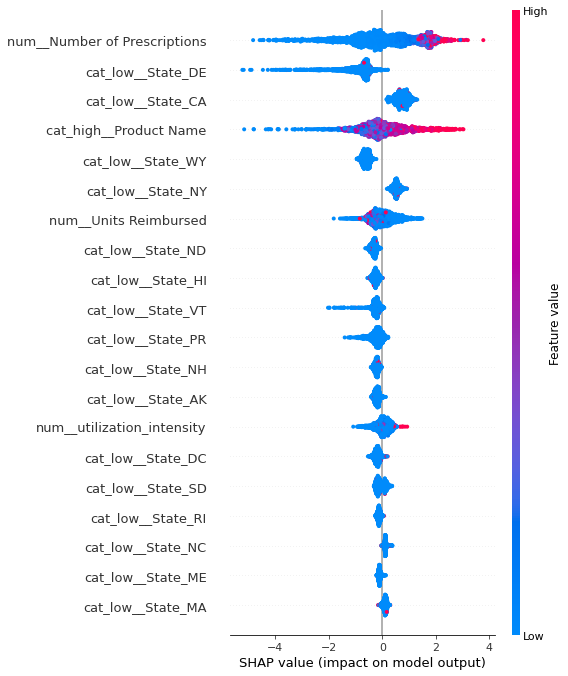

In [ ]:
import shap

preprocessor = pipeline_xgb.named_steps["preprocessing"]
xgb_model = pipeline_xgb.named_steps["model"]


X_train_processed = preprocessor.transform(X_train)

if hasattr(X_train_processed, "toarray"):
    X_train_processed = X_train_processed.toarray()

feature_names = preprocessor.get_feature_names_out()

X_sample = X_train_processed[:2000]

explainer = shap.TreeExplainer(xgb_model)

shap_values = explainer.shap_values(X_sample)

shap.summary_plot(shap_values, X_sample, feature_names=feature_names)

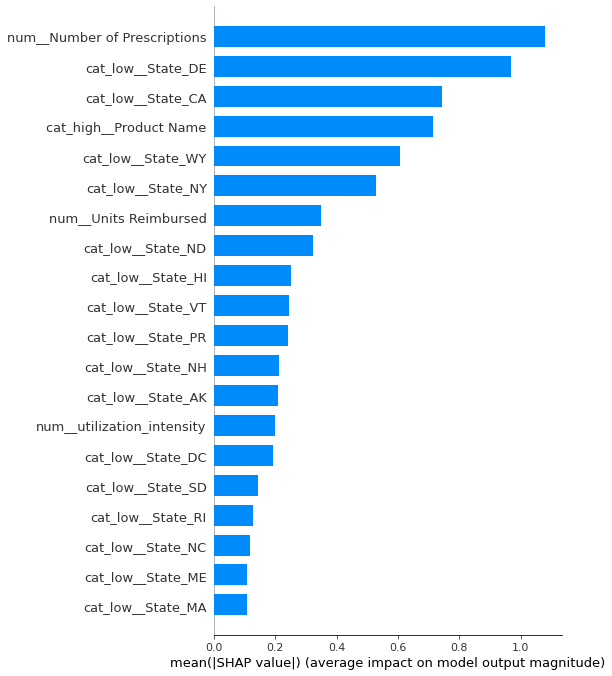

In [41]:
shap.summary_plot(
    shap_values,
    X_sample,
    feature_names=feature_names,
    plot_type="bar"
)

### **Interpretation**
The SHAP summary plot indicates that **Number of Prescriptions** is the strongest driver of predicted Medicaid drug spending, meaning increases in prescription volume substantially raise expected reimbursement levels. This confirms that utilization frequency is a primary cost determinant. **Units Reimbursed** and **Product Name (target-encoded)** also contribute meaningfully, capturing volume intensity and inherent cost differences across drugs. Together, these variables reflect demand-driven spending dynamics, where higher prescription counts and drug-specific pricing structures directly influence total expenditures.

Several state indicators (e.g., DE, CA, WY, NY) also rank highly, showing that geography strongly influences spending. Their prominence suggests that structural differences; such as program size and reimbursement policies shift baseline costs. Overall, Medicaid drug spending is driven by both utilization intensity and state-level effects, underscoring the need for state-specific cost strategies.



## **6. Business Recommendations**

### 1. Prioritize High-Volume Prescription Management
Since **Number of Prescriptions** is the strongest driver of spending, states should implement targeted utilization management strategies such as prior authorization, step therapy, and enhanced generic substitution programs to better control high-frequency prescribing and reduce unnecessary cost growth.

### 2. Benchmark High-Impact States
The strong influence of state-level effects indicates structural differences across Medicaid programs. Policymakers should benchmark high-spending states against more cost-efficient peers to identify best practices in reimbursement negotiation, formulary design, and managed care implementation.

### 3. Focus on Drug-Specific Cost Optimization
Although state effects dominate overall spending variation, **Product Name** remains influential. States should negotiate supplemental rebates for high-impact drugs and promote clinically appropriate therapeutic alternatives to improve cost efficiency.

### 4. Develop State-Specific Cost Containment Strategies
Because geographic structure significantly shifts baseline spending, uniform national policies may be less effective than tailored, state-level interventions aligned with enrollment size, disease burden, and utilization patterns.

### 5. Enhance Predictive Budget Planning
Given that utilization intensity strongly predicts spending, Medicaid administrators can integrate forecasting tools into financial planning processes to anticipate budget pressures early and proactively adjust reimbursement policies or care management strategies.

## **7. Conclusion & Next Steps**
### **7.1 Conclusion**

This project analyzed Medicaid State Drug Utilization Data to uncover key spending patterns and build a predictive model for estimating reimbursement expenditures. The findings show that Medicaid drug spending is highly concentrated among a small group of medications and strongly driven by prescription volume, with larger states accounting for a significant share of total costs. The XGBoost model achieved strong predictive performance (R² ≈ 0.85), and SHAP analysis revealed that both utilization intensity and state-level structural factors play major roles in shaping spending. Overall, the study demonstrates how predictive analytics can support data-driven decision-making, enabling proactive budget planning and more effective, state-specific cost containment strategies within Medicaid programs.

### **7.2 Next Steps**


- Integrate real-time or near real-time data feeds to transition from retrospective analysis to continuous monitoring of Medicaid drug expenditures.

- Conduct scenario analysis to evaluate the projected financial impact of future policy changes, drug launches, or shifts in disease prevalence.